# Perceptron

## Note to my future self


The important concepts in this notebook are based off 
- of Section 3.5, The perceptron, 
- of Chapter 3, Single-layer Networks, 
- of Bishop's Neural Networks for Pattern Recognition (1995). 

Tasks accomplished in this notebook:
- Part I: Train a perceptron using the pattern-by-pattern gradient-descent update rule (Equation 3.68, Page 100)
- Part II: Demonstrate the Perceptron convergence theorem (Section 3.5.3, Page 100) in action
- Part III: When data set is not linearly separable (Second paragraph, Page 103)

## Imports

In [1]:
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
norm = np.linalg.norm

## Part I - Train a Perceptron

Generate samples from two clusters, each with a standard deviation of 0.3.

In [191]:
samps, labels = make_blobs(
    n_samples=250, 
    n_features=2, 
    centers=np.array([[-0.4, -0.4], [0.5, 0.5]]), 
    cluster_std=0.24,
    center_box=(-10.0, 10.0), 
    shuffle=True, 
    random_state=324
)
samps = samps + 10
# shifting the data set a bit away from the origin can increase the number of steps
# it takes to converge; otherwise the perceptron converges too quickly, which is good
# in practice but bad for addition analysis in this notebook

Change 0 labels to -1 labels.

In [192]:
labels[labels == 0] = -1  # in accordance with the threshold activation function (Equation 3.66, Page 99)

In [193]:
labels[:10]  # sanity check

array([ 1, -1, -1,  1,  1,  1,  1, -1, -1, -1])

"Defining an extra basis function $\phi_0$ whose activation is permanently set to +1, together with a corresponding bias parameteres $w_0$." (Last paragraph, Page 98)

In [194]:
F1, F2 = np.s_[:,0], np.s_[:,1]  # a simple way to slice more elegantly

Visualize. There is one thing to look out for. "One of the difficulties with the perceptron learning rule  is that, if the data set happens not to be linearly separable, then the learning algorithm will never terminate. Furthermore, if we arbitrarily stop the learning process there is no guarantee that the weight vector found will generalize well for new data." (2nd Paragraph, Page 103) For our case, the data set is clearly linearly separable and hence does not suffer from this problem.

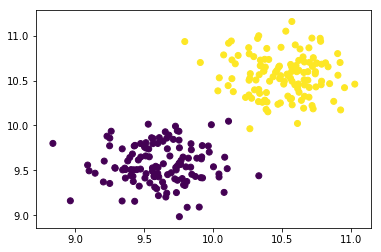

In [195]:
plt.scatter(samps[F1], samps[F2], c=labels)
plt.show()

In [196]:
samps_with_ones = np.hstack([
    samps,
    np.ones(len(samps)).reshape(len(samps), 1)  # \phi_0's
])

In [197]:
samps_with_ones[:3]  # sanity check

array([[10.335539  , 10.56417591,  1.        ],
       [10.08057497,  9.25581449,  1.        ],
       [ 9.59036198,  9.29635402,  1.        ]])

Now, we discuss the training procedure.

Define the Perceptron class.

Search for the smallest margin under the teacher weight (a strictly positive quantity):

In [198]:
class Perceptron:
    
    
    def __init__(self):
        # initial guess
        # I chose a strange initial guess so that the perceptron does not converge quickly \
        # so that I could actually see the loss decreasing over a dozens of (not just a few) weight updates
        self.w_init = np.array([[-10.0], [8.0], [-7.0]])  
        self.w = self.w_init.copy()
        self.w_histories = []
        self.num_updates = 0
        
    @staticmethod
    def step_func(input):
        """
        Activation function used by the Perceptron. (Page 99)
        """
        if input >= 0: return 1
        elif input < 0: return -1
        
    def linear_combination(self, samp_vec):
        """
        Lenght of the projection of sample vector onto the weight vector.
        Equivalent to the orthogonal distance from the decision-boundary hyperplane.
        """
        return float(self.w.T @ samp_vec)
        
    def discriminant(self, samp_vec):
        """
        Output of the Perceptron.
        """
        activation = self.step_func(
            self.linear_combination(samp_vec)
        )
        return activation
    
    def increment_weight(self, delta):
        
        self.w = self.w.copy() + delta
        self.num_updates += 1
        self.w_histories.append(self.w)
        
    def hyperplane(self, xs, w):
        ys = (- w[0]) / w[1] * xs - w[2] / w[1]
        return ys
    
    def hyperplane_histories(self, xs, num_recent=10, num_stride=1):
        hyperplanes = []
        for w in self.w_histories[-num_recent::num_stride]:
            hyperplanes.append(self.hyperplane(xs, w))
        return hyperplanes
    
#     @staticmethod
#     def cosine_angle(v1, v2):
#         return (v1.T @ v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
#     def numerator(self):
#         numerators = []
#         for r in range(self.r):
#             numerator = w_best.T @ self.w_init + (r+1) * smallest_delta
#             numerators.append(float(numerator))
#         return numerators
            
#     def denominator(self):
#         denominators = []
#         for r in range(self.r):
#             denominators.append(
#                 float(np.sqrt(np.linalg.norm(self.w_init) ** 2 + (r+1)))
#             )
#         return denominators
    
#     def w_norms(self):
#         return [float(np.linalg.norm(w)) for w in self.w_histories]

Train the perceptron. Re-compute loss after each weight update.

In [199]:
p = Perceptron()
losses = []
num_samples_seen = 0

for i in tqdm_notebook(range(5000)):
    
    for samp, label in zip(samps_with_ones, labels):
        
        num_samples_seen += 1
        samp_vec = samp.reshape(3, 1)
        
        if p.discriminant(samp_vec) * label < 0:  # misclassified
            
            # multiplying by label is just a compact way to express: 
            # if 
            # p.discriminant(samp_vec) > 0 and label < 0
            # or
            # p.discriminant(samp_vec) < 0 and label > 0
            
            p.increment_weight(samp_vec * label)  # guaranteed to reduce loss on this example
            
            # ========== proof (Equation 3.69, Page 100) ==========
            # w_new.T @ samp_vec : interpreted as the new magnitude of mistake
            #
            # if p.discriminant(samp_vec) > 0 and label < 0:
            #     w_new = w_old - samp_vec
            #     reduces error because:
            #     -> w_new.T @ samp_vec 
            #     -> = (w_old - sample_vec).T @ sample_vec
            #     -> = w_old @ sample_vec - sample_vec.T @ sample_vec (positive)
            #     -> < w_old @ sample_vec (old magnitude of mistake)
            #
            # elif p.discriminant(samp_vec) < 0 and label > 0:
            #     ... works in a similar way ...
            
            # loss computation only when w is updated
            
            loss = 0.0
    
            for samp, label in zip(samps_with_ones, labels):

                samp_vec = samp.reshape(3, 1)

                if p.discriminant(samp_vec) * label < 0:  # misclassified
                    loss -= p.linear_combination(samp_vec) * label
                    
            losses.append(loss)

In [200]:
preds = np.zeros(len(labels))
for i, s in enumerate(samps_with_ones):
    preds[i] = p.discriminant(s)
acc = np.mean(preds == labels)
print('Accuracy:', acc)

Accuracy: 1.0


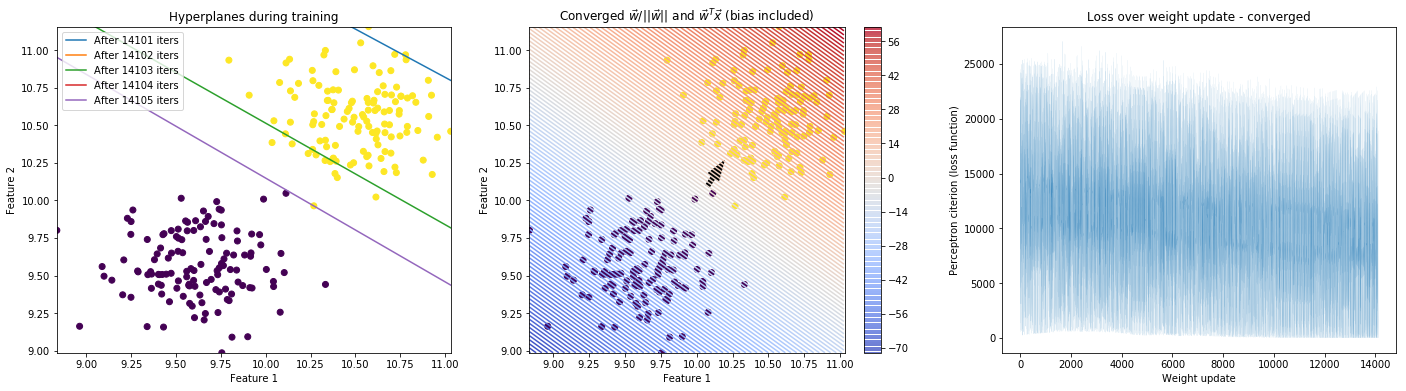

In [319]:
fig = plt.figure(figsize=(24, 6))

# figure 1

fig.add_subplot(131)

plt.scatter(samps_with_ones[F1], samps_with_ones[F2], c=labels)

y_lower, y_upper = samps_with_ones[F2].min(), samps_with_ones[F2].max()
x_lower, x_upper = samps_with_ones[F1].min(), samps_with_ones[F1].max()

xs = np.array([x_lower, x_upper])

kNUM_RECENT = 5
kNUM_STRIDE = 1
hyperplane_histories = p.hyperplane_histories(xs, num_recent=kNUM_RECENT, num_stride=kNUM_STRIDE)
num_histories = len(p.w_histories)

for i, hyperplane in enumerate(hyperplane_histories):
    plt.plot(xs, hyperplane, label=f'After {num_histories - kNUM_RECENT + (i+1) * kNUM_STRIDE} iters')
    
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)

plt.legend()
plt.title('Hyperplanes during training')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# figure 2

fig.add_subplot(132)

plt.scatter(samps_with_ones[F1], samps_with_ones[F2], c=labels)

xs = np.arange(x_lower, x_upper, 0.01)
ys = np.arange(y_lower, y_upper, 0.01)

preds_matrix = np.zeros((len(ys), len(xs)))

for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        preds_matrix[j][i] = p.linear_combination(np.array([[x], [y], [1.0]]))

plt.contour(xs, ys, preds_matrix, np.arange(np.floor(preds_matrix.min()), np.ceil(preds_matrix.max()), 1), cmap='coolwarm')
plt.colorbar()

argmax_min_y, argmax_min_x = np.where(preds_matrix == np.abs(preds_matrix).min())

plt.arrow(float(xs[argmax_min_x]), float(ys[argmax_min_y]), float(p.w[0]) / norm(p.w), float(p.w[1]) / norm(p.w), width=0.03, length_includes_head=False, color='black')

plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)

plt.title(r'Converged $\vec{w}/{||\vec{w}||}$ and $\vec{w}^T \vec{x}$ (bias included)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# figure 3

fig.add_subplot(133)

plt.plot(losses, linewidth=0.05)

is_converged = acc == 1.0
if is_converged:
    plt.title('Loss over weight update - converged')
else:
    plt.title('Loss over weight update - not converged')

plt.xlabel(f'Weight update')
plt.ylabel('Perceptron citerion (loss function)')

plt.show()

The white arrow shown in the middle plot is the normalized weight vector at convergence.

## Part II - Perceptron convergence theorem

Before we start, let's define a few quantities that will prove to be useful in the formal proof presented later.

### Perceptron weight update rule

$$
\begin{align}
\vec{w}_n &= \vec{w}_{n-1} + \eta y_n \vec{x}_n \\
\vartriangle \vec{w} \equiv \vec{w}_n - \vec{w}_{n-1} &= \eta y_n \vec{x}_n
\end{align}
$$

### Margin

$$\delta_i = \frac{ y_i {\vec{t}}^T \vec{x}_i} {||\vec{t}||}$$

- $\vec{t}$ is the teacher weight vector that can correctly classify all data points. Formally, this is writte as ($\vec{t}^T \vec{x}_i) y_i > 0, \forall i$.
- $\delta_i$ is the signed Euclidean distance from the data point $\vec{x}_i$ to the hyperplane defined by $\vec{t}$.


The smallest margin is defined by $\delta^{*} = \min_{\vec{x}}\delta > 0$, the minimum margin that can be obtained by tuning $\vec{x}$. This quantity is useful in the formal proof and hence useful in verifying the proof, so let us compute it here.

Let us use the converged weight vector `p.w` as the teacher weight, since it leads to correct classifications of all data points.

In [202]:
t = p.w

In [203]:
min_margin = np.inf
argmin_margin = None

for x, y in zip(samps_with_ones, labels):
    this_margin = y * (t.T @ x) / norm(t)
    if this_margin < min_margin: 
        min_margin = this_margin
        argmin_margin = x

In [204]:
print(min_margin)
argmin_margin

[4.32322195e-05]


array([10.26797868,  9.96379245,  1.        ])

Visualize `argmin_margin`, the data point that has the smallest margin.

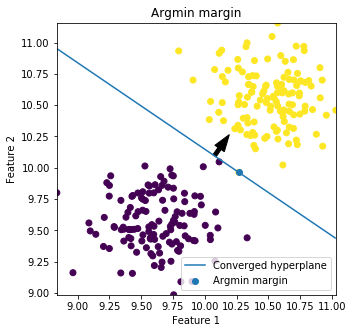

In [318]:
plt.figure(figsize=(5, 5))

plt.scatter(samps_with_ones[F1], samps_with_ones[F2], c=labels)

converged_hyperplane = p.hyperplane_histories(xs, num_recent=1, num_stride=1)[0]
plt.plot(xs, converged_hyperplane, label='Converged hyperplane')

plt.arrow(float(xs[argmax_min_x]), float(ys[argmax_min_y]), float(p.w[0]) / norm(p.w), float(p.w[1]) / norm(p.w), width=0.03, length_includes_head=False, color='black')

plt.scatter(argmin_margin[0], argmin_margin[1], label='Argmin margin')

plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)

plt.legend()
plt.title(r'Argmin margin')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

### Proof

Let $\vec{w}_n$ be the student's weight vector after $n$ weight updates. It forms an angle $theta(n)$ with $\vec{t}$. The cosine of $\theta(n)$, $c(n)$ can be computed by:

$$c(n)=\frac{\vec{w}_n^T \vec{t}}{||\vec{w}_n|| \space ||\vec{t}||}$$

**Numerator**

See the equation for margin to understand step 2 to 3. 
$$
\begin{align}
\vec{w}_n^T \vec{t} &= \vec{w}_{n-1}^T \vec{t} + \vartriangle \vec{w}_n \vec{t}\\
&= \vec{w}_{n-1}^T \vec{t} + \eta y_n \vec{w}_n^T \vec{t}\\
&= \vec{w}_{n-1}^T \vec{t} + \eta \delta_n ||\vec{t}||\\
\vec{w}_n^T \vec{t} &\geq \vec{w}_{n-1}^T \vec{t} + \eta \delta^{*} ||\vec{t}||
\end{align}
$$

Applying this inequality $n$ times, obtain:

$$\vec{w}_n^T \vec{t} \geq \vec{w}_{0}^T \vec{t} + n \eta \delta^{*} ||\vec{t}||$$

**Denominator**

Since $||\vec{t}||$ is fixed, only examine $||\vec{w_n}||$:

$$
\begin{align}
||\vec{w}_n||^2 &= ||\vec{w}_{n-1} + \vartriangle \vec{w}_n||^2 \\
&= ||\vec{w}_{n-1}||^2 + \eta^2 ||\vec{x}_n||^2 + 2(\vec{w}_{n-1}^T \vartriangle \vec{w}_n)
\end{align}
$$

$\vec{w}_{n-1}^T \vartriangle \vec{w}_n$ is negative because (1) $\vartriangle \vec{w}_n = \eta y_n \vec{x}_n$ and $\vec{w}_{n-1}^T \vec{x}_n y_n < 0$ since a mistake was made.

$$
\begin{align}
||\vec{w}_n||^2 &\leq||\vec{w}_{n-1}||^2 + \eta^2 ||\vec{x}_n||^2 \\
&\leq||\vec{w}_{n-1}||^2 + \eta^2 \max_n ||\vec{x}_n||^2 \\
&\leq||\vec{w}_{n-1}||^2 + \eta^2 D^2
\end{align}
$$

where $D = \max_n ||\vec{x}_n||^2 $.

We can easily compute $D$ by searching for the $\vec{x}_n$ that maximizes $\max_n ||\vec{x}_n||^2$:

In [207]:
D = -np.inf
for s in samps_with_ones:
    squared_norm = norm(s) ** 2
    if squared_norm > D: D = squared_norm 

In [208]:
squared_norm

187.3688106141413

Applying this inequality $n$ times, obtain:

$$||\vec{w}_n||^2 \leq ||\vec{w}_{0}||^2 + n \eta^2 D^2$$
$$||\vec{w}_n|| \leq \sqrt{||\vec{w}_{0}||^2 + n \eta^2 D^2}$$

**Putting everything together**

$$c(n) \geq \frac{\vec{w}_{0}^T \vec{t} + n \eta \delta^{*} ||\vec{t}||}{\sqrt{||\vec{w}_{0}||^2 + n \eta^2 D^2}}$$

As $n$ approaches $\infty$, the numerator grows linearly while the denominator grows only by $n^{1/2}$. Therefore, it seems that, as $n$ approaches $\infty$, $c(n)$ approaches $\infty$. However, since $c(n)$ is bounded above by $1$ as a cosine function, $n$ can't grow indefinitely. Therefore, the perceptron converges in a finite number of steps.

**In terms of angle**

Since the inverse cosine function is an monotonically decreasing function defined over domain $[-1, 1]$, the inequality reverses when it is applied to both sides of the inequality.

$$A(n) \leq \arccos ( \frac{\vec{w}_{0}^T \vec{t} + n \eta \delta^{*} ||\vec{t}||}{\sqrt{||\vec{w}_{0}||^2 + n \eta^2 D^2}} ) $$

**Disclaimer**

The derived inequality above does not say when $n$ terminates, nor does it say how $A(n)$ would fluctuate during the perceptron training process. 

**Compute upper bound of $A(n)$ as $n$ increases from $0$ to $10^{14}$**

In [291]:
def upper_bound_A(n):
    numerator = p.w_init.T @ t + n * min_margin * norm(t)
    denominator = np.sqrt(norm(p.w_init) ** 2 + n * (D ** 2)) * norm(t)
    
    if numerator / denominator > 1.0:  # convergence (numerator / denominator <= c(n), not supposed to be greater than 1)
        return 0.0
    
    if np.abs(float(numerator / denominator) - 1) < 0.000001:  # account for numerical error
        return 0.0
    
    else:  # before convergence
        return float(np.rad2deg(np.arccos(numerator / denominator)))

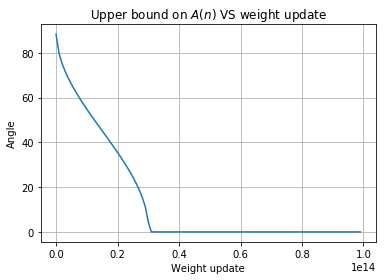

In [299]:
n_max = 10 ** 14
n_step = 10 ** 12
ns = np.arange(0, n_max, n_step)

upper_bound_As = [upper_bound_A(n+1) for n in ns]

plt.plot(ns, upper_bound_As, label=r'Upper bound on $A(n)$')

plt.grid()

plt.xlabel('Weight update')
plt.ylabel('Angle')
plt.title(r'Upper bound on $A(n)$ VS weight update')

plt.show()

However, as mentioned in the disclaimer, the upper bound does not necessarily converge to zero over a small number of $n$. In fact, as shown above, it converges at around $0.3 * 10^{14}$. As shown below, $A(n)$ has converged to zero much much earlier than this number.

In [309]:
def deg_between(v1, v2):
    cosine_angle = (v1.T @ v2) / (norm(v1) * norm(v2))
    
    # ========== Rationale for the if statement below ==========
    # When v1 is equal to v2, we expect that cosine_angle
    # is equal to 1. However, it turns out that it is larger
    # than 1 by a tiny tiny bit. This causes np.arccos to raise
    # an error because it can only handle values within [-1, 1].
    
    if np.abs(float(cosine_angle) - 1) < 0.000001:  # account for numerical error
        return 0.0
    else:
        return float(np.rad2deg(np.arccos(cosine_angle)))

In [310]:
actual_As = [deg_between(w, t) for w in p.w_histories]

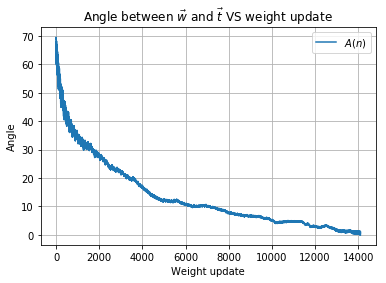

In [311]:
plt.plot(actual_As, label=r'$A(n)$')

plt.grid()

plt.legend()
plt.xlabel('Weight update')
plt.ylabel('Angle')
plt.title(r'Angle between $\vec{w}$ and $\vec{t}$ VS weight update')

plt.show()

## References

- Introduction: The Perception by Haim Sompolinsky @ MIT